# Carga de datos

## Receta
* `children` como factor
* **PRT** de variable `country` como binaria
* `agent` binaria si toma valores de `[9, 240]`
* Columnas que se consideran
    + `hotel`: Dummy
    + `adults`: Dummy
    + `meal`: Dummy
    + `market_segment`: Dummy
    + `reserved_room_type`: Dummy
    + `assigned_room_type`: Dummy
    + `customer_type`: Dummy
    + `port`: Variable de portugal
    + `agent`
    + `required_car_parking_spaces`: Factor
    + `total_of_special_requests`: Factor
    + `stays_in_weekend_nights`: Normalizada
    + `distribution_channel`: Dummy
    + `average_daily_rate`: Normalizada
    + `stays_in_week_nights`: Normalizada
    
Función de normalización: Mueve todo a cero, y hace que el mayor de los datos tenga una $\sigma = 1$ y $\mu=0$.

Random Forest Engine: `ranger`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', None)

In [2]:
# Se carga el dataset
hoteles = pd.read_csv("hoteles-entrena.csv")

#Se convierte arrival_date a tipo datetime
hoteles['arrival_date'] = pd.to_datetime(hoteles['arrival_date'])

hoteles

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date
0,Resort_Hotel,342,0,0,2,none,BB,PRT,Direct,Direct,0,0,0,C,C,3,No_Deposit,NaN,NaN,0,Transient,0.00,none,0,2015-07-01
1,Resort_Hotel,737,0,0,2,none,BB,PRT,Direct,Direct,0,0,0,C,C,4,No_Deposit,NaN,NaN,0,Transient,0.00,none,0,2015-07-01
2,Resort_Hotel,7,0,1,1,none,BB,GBR,Direct,Direct,0,0,0,A,C,0,No_Deposit,NaN,NaN,0,Transient,75.00,none,0,2015-07-01
3,Resort_Hotel,13,0,1,1,none,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No_Deposit,304.0,NaN,0,Transient,75.00,none,0,2015-07-01
4,Resort_Hotel,14,0,2,2,none,BB,GBR,Online_TA,TA/TO,0,0,0,A,A,0,No_Deposit,240.0,NaN,0,Transient,98.00,none,1,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61964,City_Hotel,115,2,4,2,none,BB,FRA,Online_TA,TA/TO,0,0,0,D,D,0,No_Deposit,9.0,NaN,0,Transient,138.00,none,2,2017-04-30
61965,City_Hotel,195,2,5,2,none,BB,FIN,Online_TA,TA/TO,0,0,0,D,D,0,No_Deposit,7.0,NaN,0,Transient,95.46,none,1,2017-04-29
61966,City_Hotel,12,2,4,3,none,BB,FRA,Online_TA,TA/TO,0,0,0,G,G,0,No_Deposit,7.0,NaN,0,Transient,206.47,none,1,2017-04-30
61967,City_Hotel,10,2,9,1,none,BB,AGO,Direct,Direct,0,0,0,D,D,5,No_Deposit,NaN,NaN,0,Transient,19.09,none,3,2017-04-26


In [3]:
features = ['children',
            'booking_changes',
            'country',
            'hotel',
            'adults',
            'meal',
            'market_segment',
            'reserved_room_type',
            'assigned_room_type',
            'customer_type',
            'port',
            'agent',
            'required_car_parking_spaces',
            'total_of_special_requests',
            'stays_in_weekend_nights',
            'distribution_channel',
            'average_daily_rate',
            'stays_in_week_nights']

In [4]:
hoteles.drop(columns=[col for col in hoteles if col not in features], inplace=True)
hoteles.head()

,hotel,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,booking_changes,agent,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests
0,Resort_Hotel,0,0,2,none,BB,PRT,Direct,Direct,C,C,3,NaN,Transient,0.0,none,0
1,Resort_Hotel,0,0,2,none,BB,PRT,Direct,Direct,C,C,4,NaN,Transient,0.0,none,0
2,Resort_Hotel,0,1,1,none,BB,GBR,Direct,Direct,A,C,0,NaN,Transient,75.0,none,0
3,Resort_Hotel,0,1,1,none,BB,GBR,Corporate,Corporate,A,A,0,304.0,Transient,75.0,none,0
4,Resort_Hotel,0,2,2,none,BB,GBR,Online_TA,TA/TO,A,A,0,240.0,Transient,98.0,none,1


In [5]:
dummies = ['adults',
           'meal',
           'market_segment',
           'reserved_room_type',
           'assigned_room_type',
           'customer_type',
           'distribution_channel',
           'total_of_special_requests']

factor = ['hotel', 'children', 'required_car_parking_spaces']

numeric = ['stays_in_weekend_nights', 'average_daily_rate', 'stays_in_week_nights', 'booking_changes']

## Encoding de variables

**Primero** las variables tipo dummy

In [6]:
for column in dummies:
    dummy = pd.get_dummies(data=hoteles[column], prefix=column)
    hoteles = pd.merge(left=hoteles, right=dummy, left_index=True, right_index=True, )
    hoteles.drop(columns=column, inplace=True)

**Segundo** las variables binarias

In [7]:
hoteles['hotel'].replace(to_replace=['Resort_Hotel', 'City_Hotel'], value=[0,1], inplace=True)
hoteles['children'].replace(to_replace=['none', 'children'], value=[0,1], inplace=True)
hoteles['required_car_parking_spaces'].replace(to_replace=['none', 'parking'], value=[0,1], inplace=True)

**Tercero**, la normalización de variables numéricas

In [8]:
scaler = MinMaxScaler()

scaled_numeric = scaler.fit_transform(hoteles[numeric])

hoteles.loc[:, numeric] = scaled_numeric

**Cuarto**, se extrae portugal como variable

In [9]:
hoteles.loc[hoteles['country'] != 'PRT', 'country'] = 0
hoteles.loc[hoteles['country'] == 'PRT', 'country'] = 1

**Quinto**, se extraen los agentes 9 y 240

In [10]:
hoteles.loc[~hoteles['agent'].isin([9, 240]), 'agent'] = 0
hoteles.loc[hoteles['agent'].isin([9, 240]), 'agent'] = 1

**Sexto**, interacción entre `booking_changes` y `country`

In [11]:
hoteles['country__bookin_changes'] = hoteles['country'] * hoteles['booking_changes']

In [12]:
hoteles

,hotel,stays_in_weekend_nights,stays_in_week_nights,children,country,booking_changes,agent,average_daily_rate,required_car_parking_spaces,adults_0,adults_1,adults_2,adults_3,adults_4,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline_TA/TO,market_segment_Online_TA,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,total_of_special_requests_0,total_of_special_requests_1,total_of_special_requests_2,total_of_special_requests_3,total_of_special_requests_4,total_of_special_requests_5,country__bookin_changes
0,0,0.000000,0.00,0,1,0.142857,0.0,0.012403,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0.142857
1,0,0.000000,0.00,0,1,0.190476,0.0,0.012403,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0.190476
2,0,0.000000,0.02,0,0,0.000000,0.0,0.158210,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0.0
3,0,0.000000,0.02,0,0,0.000000,0.0,0.158210,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0.0
4,0,0.000000,0.04,0,0,0.000000,1.0,0.202924,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61964,1,0.105263,0.08,0,0,0.000000,1.0,0.280687,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0.0
61965,1,0.105263,0.10,0,0,0.000000,0.0,0.197986,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0.0
61966,1,0.105263,0.08,0,0,0.000000,0.0,0.413799,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0.0
61967,1,0.105263,0.18,0,0,0.238095,0.0,0.049516,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.0


## Partición del dataset

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = hoteles.drop(labels='children', axis=1).to_numpy()
X.shape

(61969, 60)

In [15]:
y = hoteles['children'].to_numpy()
y.shape

(61969,)

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y)
xtrain.shape, xtest.shape

((49575, 60), (12394, 60))

In [17]:
ytrain.shape, ytest.shape

((49575,), (12394,))

Se revisa la proporción de `children` en ambos conjuntos de datos

In [18]:
ytrain.sum() / len(ytrain)

0.07463439233484619

In [19]:
ytest.sum() / len(ytest)

0.07463288688074875

# Modelo Bagging

## GridSearchCV

In [20]:
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

In [102]:
%%time

depth_array = np.zeros(shape=(20,3))

for i in np.arange(1,21,1):
    bag_dict = np.arange

    bagging = RandomForestClassifier(n_estimators=125,
                                    criterion='log_loss',
                                    max_depth=i)

    cv_bag = cross_validate(estimator=bagging,
                           X=xtrain,
                           y=ytrain,
                           cv=5,
                           scoring='neg_log_loss')

    y_val = -np.mean(cv_bag['test_score'])

    ypred = cross_val_predict(estimator=bagging,
                                X=xtest,
                                y=ytest,
                                cv=5,
                                method='predict_proba')

    loss = log_loss(y_true=ytest, y_pred=ypred)
    
    depth_array[i-1] = np.array([i, y_val, loss])

IndexError: index 20 is out of bounds for axis 0 with size 20

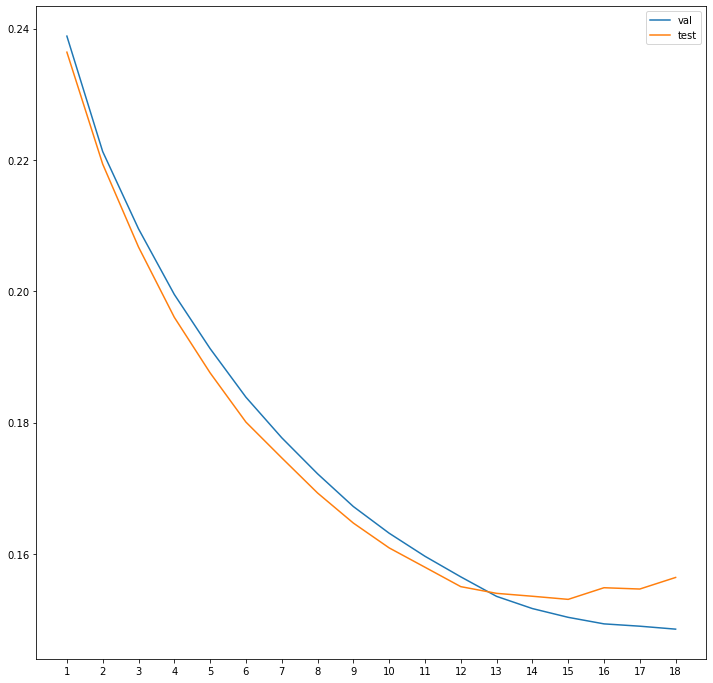

In [112]:
plt.figure(figsize=(12,12))

plt.plot(depth_array[1:-1,0], depth_array[1:-1,1], color='tab:blue', label='val')
plt.plot(depth_array[1:-1,0], depth_array[1:-1,2], color='tab:orange', label='test')

plt.xticks(ticks=depth_array[1:-1,0])
plt.legend()

plt.show()

## Entrenando un modelo con todos los datos

Transformaciones

In [21]:
columnas = hoteles.columns.to_list()
columnas.remove('children')

prueba = pd.read_csv("hoteles-prueba.csv", index_col='id')

#Se convierte arrival_date a tipo datetime
prueba['arrival_date'] = pd.to_datetime(prueba['arrival_date'])

prueba.drop(columns=[col for col in prueba if col not in features], inplace=True)

for column in dummies:
    dummy = pd.get_dummies(data=prueba[column], prefix=column)
    prueba = pd.merge(left=prueba, right=dummy, left_index=True, right_index=True, )
    prueba.drop(columns=column, inplace=True)

prueba['hotel'].replace(to_replace=['Resort_Hotel', 'City_Hotel'], value=[0,1], inplace=True)
prueba['required_car_parking_spaces'].replace(to_replace=['none', 'parking'], value=[0,1], inplace=True)

scaler = MinMaxScaler()

scaled_numeric = scaler.fit_transform(prueba[numeric])

prueba.loc[:, numeric] = scaled_numeric

prueba.loc[prueba['country'] != 'PRT', 'country'] = 0
prueba.loc[prueba['country'] == 'PRT', 'country'] = 1

prueba.loc[~prueba['agent'].isin([9, 240]), 'agent'] = 0
prueba.loc[prueba['agent'].isin([9, 240]), 'agent'] = 1

prueba['country__bookin_changes'] = prueba['country'] * prueba['booking_changes']

#Columnas faltantes
prueba[['reserved_room_type_L', 'distribution_channel_Undefined']] = 0
prueba = prueba[columnas]

prueba

,hotel,stays_in_weekend_nights,stays_in_week_nights,country,booking_changes,agent,average_daily_rate,required_car_parking_spaces,adults_0,adults_1,adults_2,adults_3,adults_4,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline_TA/TO,market_segment_Online_TA,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,total_of_special_requests_0,total_of_special_requests_1,total_of_special_requests_2,total_of_special_requests_3,total_of_special_requests_4,total_of_special_requests_5,country__bookin_changes
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0.111111,0.000000,1,0.000000,0.0,0.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0.0
2,0,0.000000,0.047619,1,0.000000,0.0,0.264706,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0.0
3,0,0.000000,0.047619,1,0.000000,0.0,0.264706,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0.0
4,0,0.000000,0.047619,1,0.055556,0.0,0.278431,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0.055556
5,0,0.444444,0.285714,1,0.000000,0.0,0.486471,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13193,1,0.222222,0.238095,0,0.000000,0.0,0.188510,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0.0
13194,1,0.222222,0.238095,0,0.000000,1.0,0.442020,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0.0
13195,1,0.222222,0.238095,0,0.000000,1.0,0.309235,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0.0


In [22]:
X_prueba = prueba.to_numpy()
X_prueba

array([[0, 0.1111111111111111, 0.0, ..., 0, 0, 0.0],
       [0, 0.0, 0.047619047619047616, ..., 0, 0, 0.0],
       [0, 0.0, 0.047619047619047616, ..., 0, 0, 0.0],
       ...,
       [1, 0.2222222222222222, 0.23809523809523808, ..., 1, 0, 0.0],
       [1, 0.2222222222222222, 0.23809523809523808, ..., 0, 0, 0.0],
       [1, 0.2222222222222222, 0.3333333333333333, ..., 0, 0, 0.0]],
      dtype=object)

Predicciones

In [23]:
bagging = RandomForestClassifier(n_estimators=125,
                                criterion='log_loss',
                                max_depth=15)

bagging.fit(X=X, y=y)

y_pred = bagging.predict_proba(X_prueba)

In [24]:
prueba['prob'] = y_pred[:,1]

prueba[['prob']].to_csv('results_bagg.csv')

In [134]:
mask = hoteles.columns.isin(prueba.columns) 

np.where(mask==False)

(array([ 3, 33, 52], dtype=int64),)

In [137]:
hoteles.columns[np.where(mask==False)]

Index(['children', 'reserved_room_type_L', 'distribution_channel_Undefined'], dtype='object')

In [133]:
prueba

,hotel,stays_in_weekend_nights,stays_in_week_nights,country,agent,average_daily_rate,required_car_parking_spaces,adults_0,adults_1,adults_2,adults_3,adults_4,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline_TA/TO,market_segment_Online_TA,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,total_of_special_requests_0,total_of_special_requests_1,total_of_special_requests_2,total_of_special_requests_3,total_of_special_requests_4,total_of_special_requests_5
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0.111111,0.000000,1,0.0,0.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
2,0,0.000000,0.047619,1,0.0,0.264706,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
3,0,0.000000,0.047619,1,0.0,0.264706,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,0,0.000000,0.047619,1,0.0,0.278431,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
5,0,0.444444,0.285714,1,0.0,0.486471,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13193,1,0.222222,0.238095,0,0.0,0.188510,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
13194,1,0.222222,0.238095,0,1.0,0.442020,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
13195,1,0.222222,0.238095,0,1.0,0.309235,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
